## Compare data

This Notebook checks how similar our return data (from the staddles) is to the returns given.
Firstly, the three ways we have calculated the long returns are compared with his data.
These are:

- Option1: straddles computed with the correct weighting
- Option2: straddles computed with the incorrect weighting (as described in the paper)
- Option3: straddles computed with zero beta instead of zero delta

Later on, the short returns are also compared with his data. There are also two different options: Correct weighting and incorrect weighting.

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import sqlalchemy as db
import sys
from scipy.interpolate import interp1d
import os
from datetime import datetime, timedelta
from scipy.stats import norm
import math
import matplotlib.dates as mdates

In [47]:
# File paths for the CSV files
file_path_1 = 'Data/Straddles/straddle_returns_correct.csv'   # correct weighting
file_path_2 = 'Data/Straddles/straddle_returns_incorrect.csv' # incorrect weighting
file_path_3 = 'Data/Straddles/straddle_returns_beta.csv' # straddles computed with the beta
file_path_4 = 'Data/Author_Data/STRADDLE_RET.csv' # his data to compare

# Reading the CSV files into Pandas DataFrames
data_1 = pd.read_csv(file_path_1)
data_2 = pd.read_csv(file_path_2)
data_3 = pd.read_csv(file_path_3)
data_4 = pd.read_csv(file_path_4,skiprows=6)

In [48]:
def DATE_STR(num):
    num_str = str(num)
    date_str = num_str[-2:]+'/'+num_str[4:-2]+'/'+num_str[0:4]
    
    return date_str 

#data_2['Date'] = data_2['Date'].apply(DATE_STR)
data_4['Date'] = pd.to_datetime(data_4['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
data_4[data_4.columns[1:]] = data_4[data_4.columns[1:]]/100

#print('Date Range:')
#print('Start:',min(data_2.DATE).date())
#print('End:',max(data_2.DATE).date())
data_1 = data_1.rename(columns={'date': 'Date'})
data_2 = data_2.rename(columns={'date': 'Date'})
data_3 = data_3.rename(columns={'date': 'Date'})

#print(data_1)
#print(data_2)

In [49]:
# Merge datasets on 'Date' column
merged_data1 = pd.merge(data_1, data_4, on='Date', how='inner')
merged_data2 = pd.merge(data_2, data_4, on='Date', how='inner')
merged_data3 = pd.merge(data_3, data_4, on='Date', how='inner')

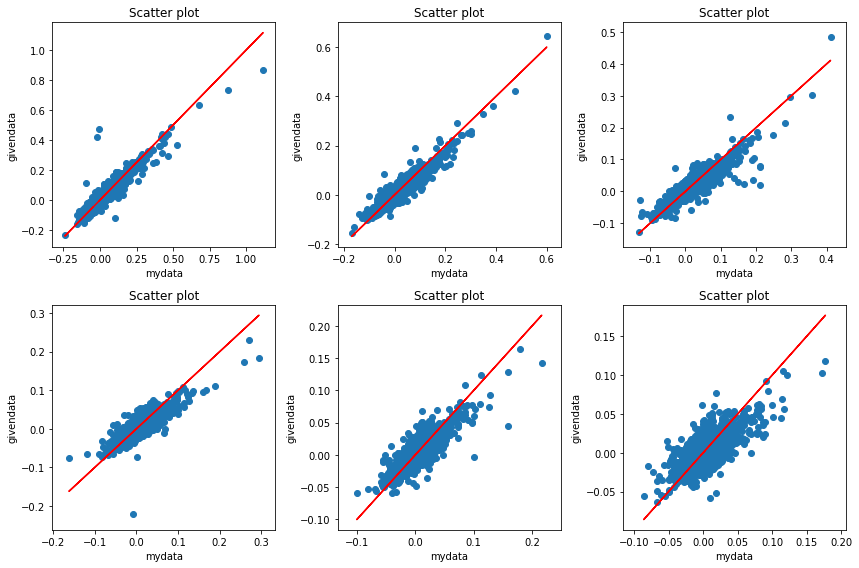

   Maturities  Correlations
0          30      0.958436
1          60      0.954783
2          90      0.922489
3         180      0.878423
4         270      0.852109
5         360      0.779068


In [50]:
# Option1: Correct weighting
result_1 = merged_data1[['Date', 'return_30', 'r_1^{straddle}']]
result_2 = merged_data1[['Date', 'return_60', 'r_2^{straddle}']]
result_3 = merged_data1[['Date', 'return_90', 'r_3^{straddle}']]
result_6 = merged_data1[['Date', 'return_180', 'r_6^{straddle}']]
result_9 = merged_data1[['Date', 'return_270', 'r_9^{straddle}']]
result_12 = merged_data1[['Date', 'return_360', 'r_12^{straddle}']]
resultlist = [result_1, result_2, result_3, result_6, result_9, result_12]

# Calculate the number of plots to create
num_plots = len(resultlist)

# Calculate the number of rows and columns for subplots
num_cols = 3  # Number of plots to display in a row
num_rows = - (-num_plots // num_cols)  # Rounds up the division to the nearest whole number

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))  # Adjust figsize as needed

# Flatten the axes if the number of subplots is less than num_rows x num_cols
axes = axes.flatten()

for i in range(num_plots):
    result = resultlist[i]
    ax = axes[i]
    ax.scatter(result.iloc[:, 1], result.iloc[:, 2])
    ax.plot(result.iloc[:, 1], result.iloc[:, 1], color='red')  # Line for correlation = 1
    ax.set_xlabel('mydata')
    ax.set_ylabel('givendata')
    ax.set_title('Scatter plot')

# Hide empty subplots if the number of plots doesn't fill all the subplots
for i in range(num_plots, num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Calculate correlation
correlation1 = result_1['return_30'].corr(result_1['r_1^{straddle}'])
correlation2 = result_2['return_60'].corr(result_2['r_2^{straddle}'])
correlation3 = result_3['return_90'].corr(result_3['r_3^{straddle}'])
correlation6 = result_6['return_180'].corr(result_6['r_6^{straddle}'])
correlation9 = result_9['return_270'].corr(result_9['r_9^{straddle}'])
correlation12 = result_12['return_360'].corr(result_12['r_12^{straddle}'])
data = {
    'Maturities': [30, 60, 90, 180, 270, 360],
    'Correlations': [correlation1, correlation2, correlation3, correlation6, correlation9,correlation12]
}

# Create a DataFrame
df = pd.DataFrame(data)
print(df)

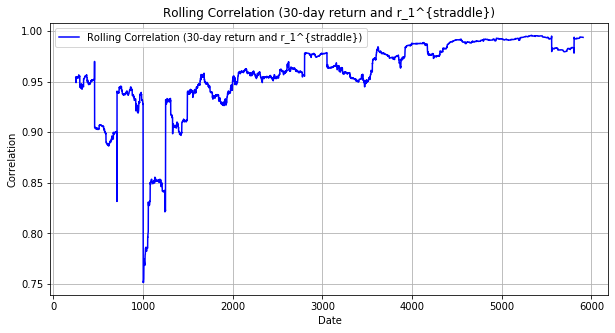

In [51]:
# Calculate the rolling correlation with a window of 250 observations
rolling_corr = result_1['return_30'].rolling(window=250).corr(result_1['r_1^{straddle}'])

# Plot the rolling correlation
plt.figure(figsize=(10, 5))
plt.plot(rolling_corr, label='Rolling Correlation (30-day return and r_1^{straddle})', color='blue')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('Rolling Correlation (30-day return and r_1^{straddle})')
plt.legend()
plt.grid(True)
plt.show()

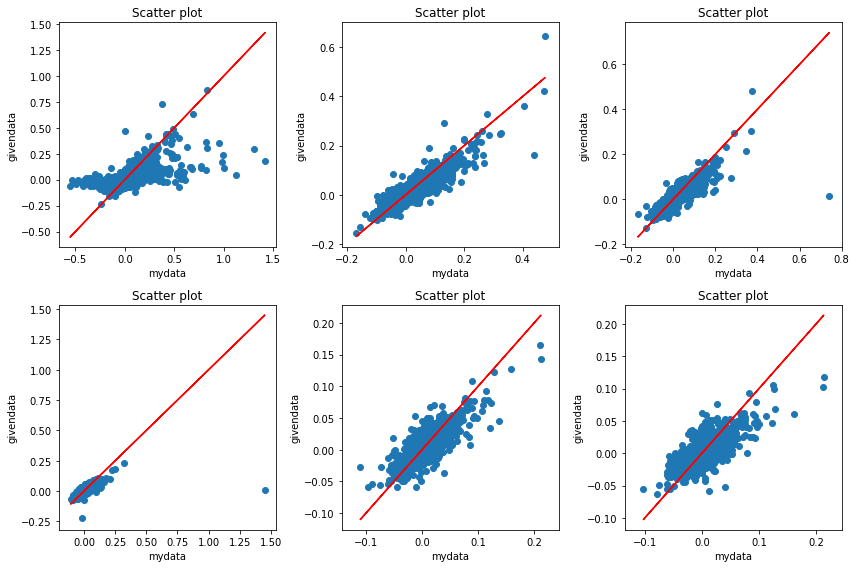

   Maturities  Correlations
0          30      0.699405
1          60      0.916906
2          90      0.860781
3         180      0.649732
4         270      0.826729
5         360      0.761063


In [52]:
# Option2: Incorrect weighting
#Keep only 'Date' and the second column from both datasets
result_1 = merged_data2[['Date', 'return_30', 'r_1^{straddle}']]
result_2 = merged_data2[['Date', 'return_60', 'r_2^{straddle}']]
result_3 = merged_data2[['Date', 'return_90', 'r_3^{straddle}']]
result_6 = merged_data2[['Date', 'return_180', 'r_6^{straddle}']]
result_9 = merged_data2[['Date', 'return_270', 'r_9^{straddle}']]
result_12 = merged_data2[['Date', 'return_360', 'r_12^{straddle}']]
resultlist = [result_1, result_2, result_3, result_6, result_9, result_12]

# Assuming resultlist is a list of DataFrames
# Calculate the number of plots to create
num_plots = len(resultlist)

# Calculate the number of rows and columns for subplots
num_cols = 3  # Number of plots to display in a row
num_rows = - (-num_plots // num_cols)  # Rounds up the division to the nearest whole number

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))  # Adjust figsize as needed

# Flatten the axes if the number of subplots is less than num_rows x num_cols
axes = axes.flatten()

for i in range(num_plots):
    result = resultlist[i]
    ax = axes[i]
    ax.scatter(result.iloc[:, 1], result.iloc[:, 2])
    ax.plot(result.iloc[:, 1], result.iloc[:, 1], color='red')  # Line for correlation = 1
    ax.set_xlabel('mydata')
    ax.set_ylabel('givendata')
    ax.set_title('Scatter plot')

# Hide empty subplots if the number of plots doesn't fill all the subplots
for i in range(num_plots, num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Calculate correlation
correlation1 = result_1['return_30'].corr(result_1['r_1^{straddle}'])
correlation2 = result_2['return_60'].corr(result_2['r_2^{straddle}'])
correlation3 = result_3['return_90'].corr(result_3['r_3^{straddle}'])
correlation6 = result_6['return_180'].corr(result_6['r_6^{straddle}'])
correlation9 = result_9['return_270'].corr(result_9['r_9^{straddle}'])
correlation12 = result_12['return_360'].corr(result_12['r_12^{straddle}'])
data = {
    'Maturities': [30, 60, 90, 180, 270, 360],
    'Correlations': [correlation1, correlation2, correlation3, correlation6, correlation9,correlation12]
}

# Create a DataFrame
df = pd.DataFrame(data)
print(df)

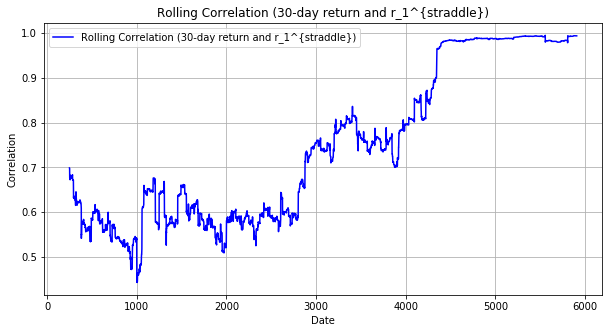

In [53]:
# Calculate the rolling correlation with a window of 250 observations
rolling_corr = result_1['return_30'].rolling(window=250).corr(result_1['r_1^{straddle}'])

# Plot the rolling correlation
plt.figure(figsize=(10, 5))
plt.plot(rolling_corr, label='Rolling Correlation (30-day return and r_1^{straddle})', color='blue')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('Rolling Correlation (30-day return and r_1^{straddle})')
plt.legend()
plt.grid(True)
plt.show()

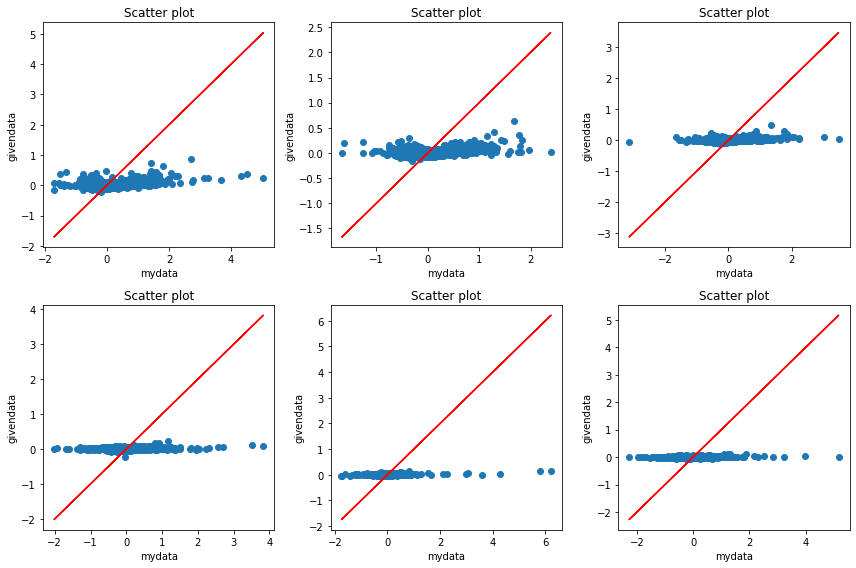

   Maturities  Correlations
0          30      0.344657
1          60      0.293942
2          90      0.265959
3         180      0.205868
4         270      0.224752
5         360      0.151520


In [45]:
# Option3: calculating the returns directly via the betas
#Keep only 'Date' and the second column from both datasets
result_1 = merged_data3[['Date', 'return_30', 'r_1^{straddle}']]
result_2 = merged_data3[['Date', 'return_60', 'r_2^{straddle}']]
result_3 = merged_data3[['Date', 'return_90', 'r_3^{straddle}']]
result_6 = merged_data3[['Date', 'return_180', 'r_6^{straddle}']]
result_9 = merged_data3[['Date', 'return_270', 'r_9^{straddle}']]
result_12 = merged_data3[['Date', 'return_360', 'r_12^{straddle}']]
resultlist = [result_1, result_2, result_3, result_6, result_9, result_12]

# Assuming resultlist is a list of DataFrames
# Calculate the number of plots to create
num_plots = len(resultlist)

# Calculate the number of rows and columns for subplots
num_cols = 3  # Number of plots to display in a row
num_rows = - (-num_plots // num_cols)  # Rounds up the division to the nearest whole number

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))  # Adjust figsize as needed

# Flatten the axes if the number of subplots is less than num_rows x num_cols
axes = axes.flatten()

for i in range(num_plots):
    result = resultlist[i]
    ax = axes[i]
    ax.scatter(result.iloc[:, 1], result.iloc[:, 2])
    ax.plot(result.iloc[:, 1], result.iloc[:, 1], color='red')  # Line for correlation = 1
    ax.set_xlabel('mydata')
    ax.set_ylabel('givendata')
    ax.set_title('Scatter plot')

# Hide empty subplots if the number of plots doesn't fill all the subplots
for i in range(num_plots, num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Calculate correlation
correlation1 = result_1['return_30'].corr(result_1['r_1^{straddle}'])
correlation2 = result_2['return_60'].corr(result_2['r_2^{straddle}'])
correlation3 = result_3['return_90'].corr(result_3['r_3^{straddle}'])
correlation6 = result_6['return_180'].corr(result_6['r_6^{straddle}'])
correlation9 = result_9['return_270'].corr(result_9['r_9^{straddle}'])
correlation12 = result_12['return_360'].corr(result_12['r_12^{straddle}'])
data = {
    'Maturities': [30, 60, 90, 180, 270, 360],
    'Correlations': [correlation1, correlation2, correlation3, correlation6, correlation9,correlation12]
}

# Create a DataFrame
df = pd.DataFrame(data)
print(df)

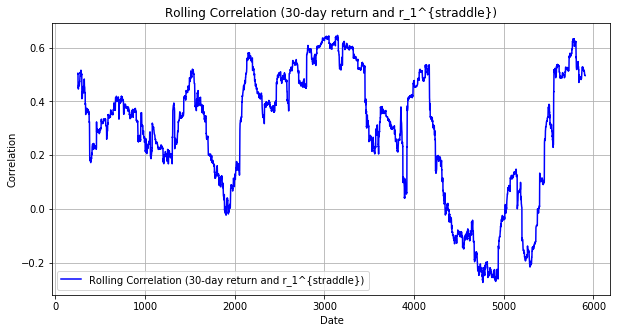

In [32]:
# Calculate the rolling correlation with a window of 250 observations
rolling_corr = result_1['return_30'].rolling(window=250).corr(result_1['r_1^{straddle}'])

# Plot the rolling correlation
plt.figure(figsize=(10, 5))
plt.plot(rolling_corr, label='Rolling Correlation (30-day return and r_1^{straddle})', color='blue')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('Rolling Correlation (30-day return and r_1^{straddle})')
plt.legend()
plt.grid(True)
plt.show()

As one can observe, the first option with the correct weighting is closest to his data. The straddle returns computed with the beta method is completely different, the one with the correct weighting is okay, bit still worse.
We will be using the correct weighting going forward with our analysis.

In [54]:
# Import datasets
# File paths for the CSV files
file_path_5 = 'Data/Straddles/short_straddle_returns_correct.csv'   # correct weighting
file_path_6 = 'Data/Straddles/short_straddle_returns_incorrect.csv' # incorrect weighting

# Reading the CSV files into Pandas DataFrames
data_5 = pd.read_csv(file_path_5)
data_6 = pd.read_csv(file_path_6)

In [55]:
# Merge datasets on 'Date' column
merged_data4 = pd.merge(data_5, data_4, on='Date', how='inner')
merged_data5 = pd.merge(data_6, data_4, on='Date', how='inner')

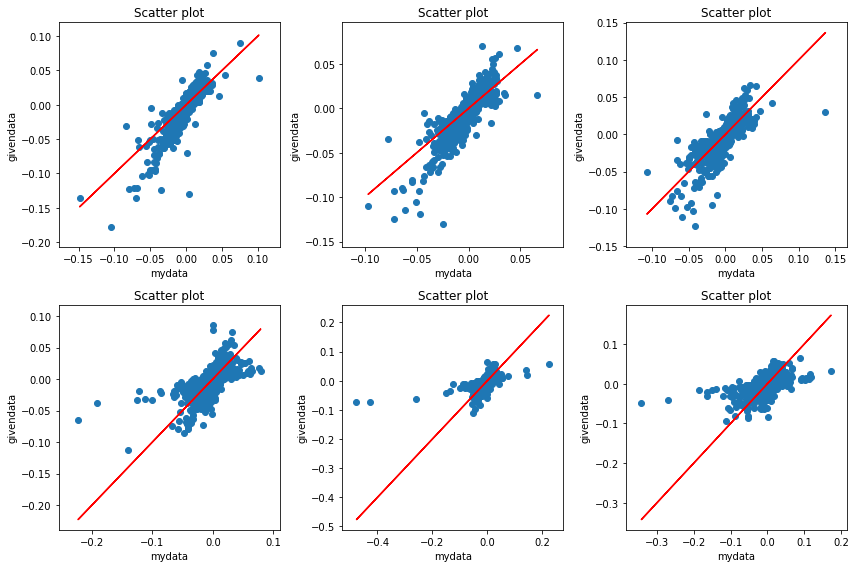

   Maturities  Correlations
0          30      0.901564
1          60      0.888041
2          90      0.822844
3         180      0.671091
4         270      0.558728
5         360      0.583863


In [56]:
#Option1: Correct weighting
result_1 = merged_data4[['Date', 'r_v_30', 'r_1^{short straddle}']]
result_2 = merged_data4[['Date', 'r_v_60', 'r_2^{short straddle}']]
result_3 = merged_data4[['Date', 'r_v_90', 'r_3^{short straddle}']]
result_6 = merged_data4[['Date', 'r_v_180', 'r_6^{short straddle}']]
result_9 = merged_data4[['Date', 'r_v_270', 'r_9^{short straddle}']]
result_12 = merged_data4[['Date', 'r_v_360', 'r_12^{short straddle}']]
resultlist = [result_1, result_2, result_3, result_6, result_9, result_12]

# plot and get correlation
# Assuming resultlist is a list of DataFrames
# Calculate the number of plots to create
num_plots = len(resultlist)

# Calculate the number of rows and columns for subplots
num_cols = 3  # Number of plots to display in a row
num_rows = - (-num_plots // num_cols)  # Rounds up the division to the nearest whole number

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))  # Adjust figsize as needed

# Flatten the axes if the number of subplots is less than num_rows x num_cols
axes = axes.flatten()

for i in range(num_plots):
    result = resultlist[i]
    ax = axes[i]
    ax.scatter(result.iloc[:, 1], result.iloc[:, 2])
    ax.plot(result.iloc[:, 1], result.iloc[:, 1], color='red')  # Line for correlation = 1
    ax.set_xlabel('mydata')
    ax.set_ylabel('givendata')
    ax.set_title('Scatter plot')

# Hide empty subplots if the number of plots doesn't fill all the subplots
for i in range(num_plots, num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Calculate correlation
correlation1 = result_1['r_v_30'].corr(result_1['r_1^{short straddle}'])
correlation2 = result_2['r_v_60'].corr(result_2['r_2^{short straddle}'])
correlation3 = result_3['r_v_90'].corr(result_3['r_3^{short straddle}'])
correlation6 = result_6['r_v_180'].corr(result_6['r_6^{short straddle}'])
correlation9 = result_9['r_v_270'].corr(result_9['r_9^{short straddle}'])
correlation12 = result_12['r_v_360'].corr(result_12['r_12^{short straddle}'])
data = {
    'Maturities': [30, 60, 90, 180, 270, 360],
    'Correlations': [correlation1, correlation2, correlation3, correlation6, correlation9,correlation12]
}

# Create a DataFrame
df = pd.DataFrame(data)
print(df)

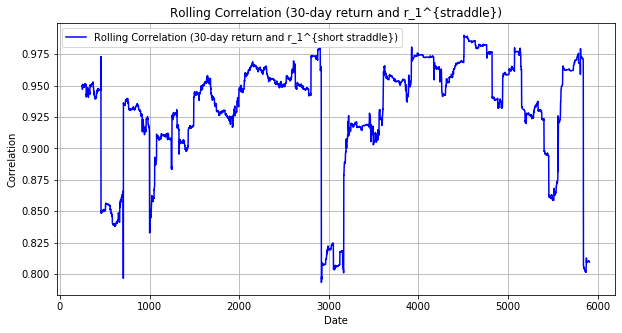

In [57]:
# Calculate the rolling correlation with a window of 250 observations
rolling_corr = result_1['r_v_30'].rolling(window=250).corr(result_1['r_1^{short straddle}'])

# Plot the rolling correlation
plt.figure(figsize=(10, 5))
plt.plot(rolling_corr, label='Rolling Correlation (30-day return and r_1^{short straddle})', color='blue')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('Rolling Correlation (30-day return and r_1^{straddle})')
plt.legend()
plt.grid(True)
plt.show()

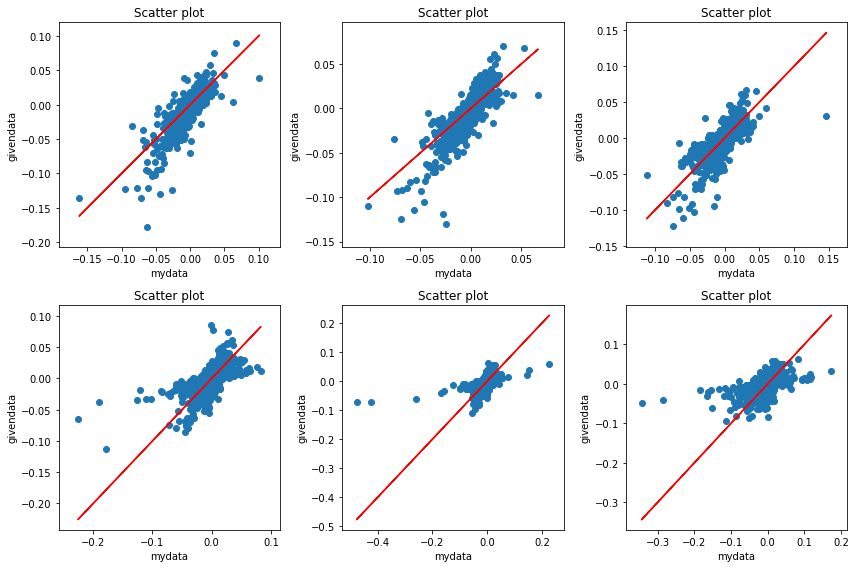

   Maturities  Correlations
0          30      0.856266
1          60      0.870863
2          90      0.796195
3         180      0.660793
4         270      0.545001
5         360      0.563972


In [58]:
# Option2: Incorrect weighting
result_1 = merged_data5[['Date', 'r_v_30', 'r_1^{short straddle}']]
result_2 = merged_data5[['Date', 'r_v_60', 'r_2^{short straddle}']]
result_3 = merged_data5[['Date', 'r_v_90', 'r_3^{short straddle}']]
result_6 = merged_data5[['Date', 'r_v_180', 'r_6^{short straddle}']]
result_9 = merged_data5[['Date', 'r_v_270', 'r_9^{short straddle}']]
result_12 = merged_data5[['Date', 'r_v_360', 'r_12^{short straddle}']]
resultlist = [result_1, result_2, result_3, result_6, result_9, result_12]

# plot and get correlation
# Assuming resultlist is a list of DataFrames
# Calculate the number of plots to create
num_plots = len(resultlist)

# Calculate the number of rows and columns for subplots
num_cols = 3  # Number of plots to display in a row
num_rows = - (-num_plots // num_cols)  # Rounds up the division to the nearest whole number

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))  # Adjust figsize as needed

# Flatten the axes if the number of subplots is less than num_rows x num_cols
axes = axes.flatten()

for i in range(num_plots):
    result = resultlist[i]
    ax = axes[i]
    ax.scatter(result.iloc[:, 1], result.iloc[:, 2])
    ax.plot(result.iloc[:, 1], result.iloc[:, 1], color='red')  # Line for correlation = 1
    ax.set_xlabel('mydata')
    ax.set_ylabel('givendata')
    ax.set_title('Scatter plot')

# Hide empty subplots if the number of plots doesn't fill all the subplots
for i in range(num_plots, num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Calculate correlation
correlation1 = result_1['r_v_30'].corr(result_1['r_1^{short straddle}'])
correlation2 = result_2['r_v_60'].corr(result_2['r_2^{short straddle}'])
correlation3 = result_3['r_v_90'].corr(result_3['r_3^{short straddle}'])
correlation6 = result_6['r_v_180'].corr(result_6['r_6^{short straddle}'])
correlation9 = result_9['r_v_270'].corr(result_9['r_9^{short straddle}'])
correlation12 = result_12['r_v_360'].corr(result_12['r_12^{short straddle}'])
data = {
    'Maturities': [30, 60, 90, 180, 270, 360],
    'Correlations': [correlation1, correlation2, correlation3, correlation6, correlation9,correlation12]
}

# Create a DataFrame
df = pd.DataFrame(data)
print(df)

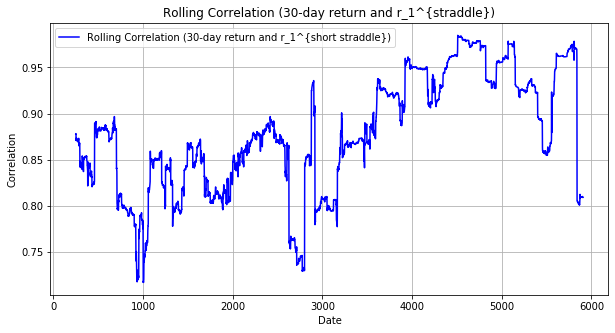

In [59]:
# Calculate the rolling correlation with a window of 250 observations
rolling_corr = result_1['r_v_30'].rolling(window=250).corr(result_1['r_1^{short straddle}'])

# Plot the rolling correlation
plt.figure(figsize=(10, 5))
plt.plot(rolling_corr, label='Rolling Correlation (30-day return and r_1^{short straddle})', color='blue')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('Rolling Correlation (30-day return and r_1^{straddle})')
plt.legend()
plt.grid(True)
plt.show()

One can clearly see that the correct weighting is closer to his data for every maturity. The results are, especially for longer maturities, not equally as close to his data as for the long straddle returns.